# Reuters News Headlines
This project focuses on the application of deep learning to natural language processing.
I will be working with a subset of Reuters news headlines that are collected over 15 months,
covering all of 2019, plus a few months in 2018 and in a few months of this year.

In particular, I will be building an **autoencoder** of news headlines.
I will have an **encoder** that maps a news headline to a vector embedding, and then a **decoder** that reconstructs
the news headline. Both our encoder and decoder networks will be Recurrent Neural Networks,
I will build: 

- a neural network that takes a sequence as an input
- a neural network that generates a sequence as an output

This project is organized as follows:

- Exploring the data
- Building the autoencoder
- Training the autoencoder using *data augmentation*
- Analyzing the embeddings (interpolating between headlines)

Furthermore, I use **data augmentation** for improving of
the robustness of the autoencoder, as proposed by Shen et al [1].

[1] Shen et al (2019) "Educating Text Autoencoders: Latent Representation Guidance via Denoising" https://arxiv.org/pdf/1905.12777.pdf

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
import random

%matplotlib inline


First I upload the files `reuters_train.txt` and `reuters_valid.txt` to Google Drive so I can access them through Google Colab easily.



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
train_path = '/content/drive/My Drive/reuters_train.txt'
valid_path = '/content/drive/My Drive/reuters_valid.txt'

I'll be using a `TabularDataset` to load my data, which works well on structured
CSV data with fixed columns (e.g. a column for the sequence, a column for the label). My tabular dataset
is even simpler: I have no labels, just some text. So, I am treating my data as a table with one field
representing the sequence.

In [0]:
import torchtext

# Tokenization function to separate a headline into words
def tokenize_headline(headline):
    """Returns the sequence of words in the string headline. I also
    prepend the "<bos>" or beginning-of-string token, and append the
    "<eos>" or end-of-string token to the headline.
    """
    return ("<bos> " + headline + " <eos>").split()

# Data field (column) representing our *text*.
text_field = torchtext.data.Field(
    sequential=True,            # this field consists of a sequence
    tokenize=tokenize_headline, # how to split sequences into words
    include_lengths=True,       # to track the length of sequences, for batching
    batch_first=True,           # similar to batch_first=True in nn.RNN demonstrated in lecture
    use_vocab=True)             # to turn each character into an integer index
train_data = torchtext.data.TabularDataset(
    path=train_path,                # data file path
    format="tsv",                   # fields are separated by a tab
    fields=[('title', text_field)]) # list of fields (I have only one)


Histograms of the number of words per headline in our training set.
Excluding the `<bos>` and `<eos>` tags in my computation.


171443
['<bos>', 'u.s.', 'navy', 'pursuing', 'block', 'buy', 'of', 'two', 'aircraft', 'carriers', '-', 'senator', '<eos>']


<function matplotlib.pyplot.show>

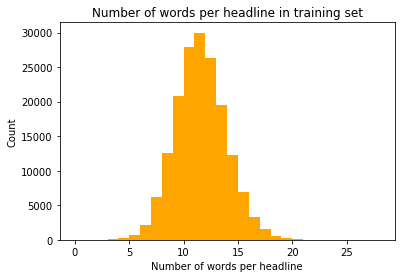

In [5]:
print(len(train_data))

print(train_data[5].title)
lens = [len(example.title) - 2 for example in train_data]
plt.hist(lens, bins = [i for i in range(max(lens))], color="orange")
plt.title('Number of words per headline in training set')
plt.xlabel('Number of words per headline')
plt.ylabel('Count')
plt.show

# I found this histogram useful to see the distribution of
# headline lengths. This allowed me to make decisions about the kind of model 
# I should use. For instance, the size of the hidden layer/the embedding size
# depends on the length of the sequences. Since, if a single headline can be 200 words 
# long, then the size of the embedding needs to be large enough to 
# to represent this headline.


Number of distinct words appear in the training data: 
Excluding the `<bos>` and `<eos>` tags.

In [0]:
from collections import Counter
train_words = np.concatenate([np.array(i[1:-1]) for i in train_data.title])
c = Counter(train_words)
total_distinct = len(c.keys())
print(f"Number of distinct words: {total_distinct}")

Number of distinct words: 51298



The distribution of *words* will have a long tail, meaning that there are some words
that will appear very often, and many words that will appear infrequently.


In [8]:
# Extra info just for better understanding of the data
from collections import Counter
train_words = np.concatenate([np.array(i[1:-1]) for i in train_data.title])
c = Counter(train_words)
print("10 Most common words")
for entry in c.most_common(10):
	print(" Word: {0:3} Count: {1}".format(entry[0], entry[1]))
print('\n','--'*25)

#Part (c):
counts = np.array(list(c.most_common()))
print("\nNumber of words that appear exactly once: ",sum(counts[:,1]=='1'))
print("\nNumber of words that appear exactly twice:", sum(counts[:,1]=='2'))

10 Most common words
 Word: to  Count: 58452
 Word: ,   Count: 43088
 Word: in  Count: 38538
 Word: 's  Count: 34580
 Word: _num_ Count: 31340
 Word: :   Count: 28052
 Word: on  Count: 24794
 Word: of  Count: 22895
 Word: for Count: 22163
 Word: u.s. Count: 19320

 --------------------------------------------------

Number of words that appear exactly once:  19854

Number of words that appear exactly twice: 7193


In [0]:
# Using the <unk> tag instead of learning embeddings for rare words allows 
# me to embed unseen words. For example, if I come across a word in the validation
# set that I didn't see in the training set, then I still have an embedding 
# for the word. Thus, I would rather replace infrequent words with <unk> tags
# so I have a better way of dealing with both, words that appear out of 
# vocabulary and infrequently.
# In this way, the model will learn to handle all unseen words and words for 
# which there are not enough training points. The model will be able to leverage
# the context of the <unk> words to learn how to handle this case, and make 
# good predictions even in the validation and test sets.


I will only model the top 9995 words in the training set, excluding the tags
`<bos>`, `<eos>`, and other possible tags
(including those, I will have a vocabulary size of exactly 10000 tokens).



In [13]:
train_words = np.concatenate([np.array(i[1:-1]) for i in train_data.title])
c = Counter(train_words)

total_occ = sum(c.values()) # total word occurrences
top_occ = 0 # top word occurrences
for entry in c.most_common(9995): top_occ += entry[1]
print(f"Word occurrences that will be supported: {(100 * (top_occ / total_occ)):.2f}%")
print(f"Word occurrences that will be set to the <unk> tag: {(100 * (1 - top_occ / total_occ)):.2f}%")

Word occurrences that will be supported: 93.98%
Word occurrences that will be set to the <unk> tag: 6.02%


Our `torchtext` package will help us keep track of our list of unique words, known
as a **vocabulary**. A vocabulary also assigns a unique integer index to each word.


In [0]:
# Building the vocabulary based on the training data. The vocabulary
# can have at most 9997 words (9995 words + the <bos> and <eos> token)
text_field.build_vocab(train_data, max_size=9997)

# This vocabulary object will be helpful
vocab = text_field.vocab
print(vocab.stoi["hello"]) # for instances, I can convert from string to (unique) index
print(vocab.itos[10])      # ... and from word index to string

# The size of my vocabulary is actually 10000
vocab_size = len(text_field.vocab.stoi)
print(vocab_size) # should be 10000

# The reason is that torchtext adds two more tokens for us:
print(vocab.itos[0]) # <unk> represents an unknown word not in my vocabulary
print(vocab.itos[1]) # <pad> will be used to pad short sequences for batching

0
on
10000
<unk>
<pad>



Here is a diagram showing my desired architecture:

<img src="https://www.cs.toronto.edu/~lczhang/321/hw/p4model.png" width="95%" />

There are two main components to the model: the **encoder** and the **decoder**.
As always with neural networks, I'll first describe how to make
**predictions** with of these components. Let's get started:

The **encoder** will take a sequence of words (a headline) as *input*, and produce an
embedding (a vector) that represents the entire headline. In the diagram above,
the vector ${\bf h}^{(7)}$ is the vector embedding containing information about 
the entire headline.

The **decoder** will take an embedding (in the diagram, the vector ${\bf h}^{(7)}$) as input,
and uses a separate RNN to **generate a sequence of words**. To generate a sequence of words,
the decoder needs to do the following:

1) Determine the previous word that was generated. This previous word will act as ${\bf x}^{(t)}$
   to our RNN, and will be used to update the hidden state ${\bf m}^{(t)}$. Since each of our
   sequences begin with the `<bos>` token, I'll set ${\bf x}^{(1)}$ to be the `<bos>` token.
2) Compute the updates to the hidden state ${\bf m}^{(t)}$ based on the previous hidden state
   ${\bf m}^{(t-1)}$ and ${\bf x}^{(t)}$. Intuitively, this hidden state vector ${\bf m}^{(t)}$
   is a representation of *all the words I still need to generate*.
3) I'll use a fully-connected layer to take a hidden state ${\bf m}^{(t)}$, and determine
   *what the next word should be*. This fully-connected layer solves a *classification problem*,
   since I am trying to choose a word out of $K=10000$ distinct words. As in a classification
   problem, the fully-connected neural network will compute a *probability distribution* over
   these 10,000 words. In the diagram, I am using ${\bf z}^{(t)}$ to represent the logits,
   or the pre-softmax activation values representing the probability distribution.
4) I will need to *sample* an actual word from this probability distribution ${\bf z}^{(t)}$.
   I can do this in a number of ways.
5) This word I choose will become the next input ${\bf x}^{(t+1)}$ to our RNN, which is used
   to update our hidden state ${\bf m}^{(t+1)}$---i.e. to determine what are the remaining
   words to be generated.

I can repeat this process until I see an `<eos>` token generated, or until the generated
sequence becomes too long.

Unfortunately, I can't *train* this autoencoder in the way I just described. That is,
I can't just compare our generated sequence with our ground-truth sequence, and get
gradients. Both sequences are **discrete** entities, so I won't be able to compute
gradients at all! In particular, **sampling is a discrete process**, and so I won't be
able to back-propagate through any kind of sampling that I do.

Fortunately, there is one very well-established solution called
**teacher forcing** which I can use for training:
instead of *sampling* the next word based on ${\bf z}^{(t)}$, I will forgo sampling,
and use the **ground truth** ${\bf x}^{(t)}$ in the next step.

Here is a diagram showing how I can use **teacher forcing** to train our model:

<img src="https://www.cs.toronto.edu/~lczhang/321/hw/p4model_tf.png" width="95%" />

I will use the RNN generator to compute the logits
${\bf z}^{(1)},{\bf z}^{(2)},  \cdots {\bf z}^{(T)}$. These distributions
can be compared to the ground-truth words using the cross-entropy loss.
The loss function for this model will be the sum of the losses across each $t$.
(This is similar to what I did in a pixel-wise prediction problem.)

I'll train the encoder and decoder model simultaneously. There are several components
to our model that contain tunable weights:

- The word embedding that maps a word to a vector representation.
  The word embedding component is represented with blue arrows in the diagram.
- The encoder RNN (which will use Gated Recurrent Units) that computes the
  embedding over the entire headline. The encoder RNN 
  is represented with black arrows in the diagram.
- The decoder RNN (which will also use Gated Recurrent Units) that computes
  hidden states, which are vectors representing what words are to be generated.
  The decoder RNN is represented with gray arrows in the diagram.
- The **projection MLP** (a fully-connected layer) that computes
  a distribution over the next word to generate, given a decoder RNN hidden
  state.



In [0]:
class AutoEncoder(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size):
        """
        A text autoencoder. The parameters 
            - vocab_size: number of unique words/tokens in the vocabulary
            - emb_size: size of the word embeddings $x^{(t)}$
            - hidden_size: size of the hidden states in both the
                           encoder RNN ($h^{(t)}$) and the
                           decoder RNN ($m^{(t)}$)
        """
        super().__init__()
        self.embed = nn.Embedding(num_embeddings=vocab_size,
                                  embedding_dim=emb_size)  
        self.encoder_rnn = nn.GRU(input_size=emb_size, 
                                  hidden_size=hidden_size,
                                  batch_first=True)
        self.decoder_rnn = nn.GRU(input_size=emb_size,
                                  hidden_size=hidden_size,
                                  batch_first=True)
        self.proj = nn.Linear(in_features=hidden_size,
                              out_features=vocab_size)

    def encode(self, inp):
        """
        Computes the encoder output given a sequence of words.
        """
        emb = self.embed(inp)
        out, last_hidden = self.encoder_rnn(emb)
        return last_hidden

    def decode(self, inp, hidden=None):
        """
        Computes the decoder output given a sequence of words, and
        (optionally) an initial hidden state.
        """
        emb = self.embed(inp)
        out, last_hidden = self.decoder_rnn(emb, hidden)
        out_seq = self.proj(out)
        return out_seq, last_hidden

    def forward(self, inp):
        """
        Compute both the encoder and decoder forward pass
        given an integer input sequence inp with shape [batch_size, seq_length],
        with inp[a,b] representing the (index in our vocabulary of) the b-th word
        of the a-th training example.

        This function should return the logits $z^{(t)}$ in a tensor of shape
        [batch_size, seq_length - 1, vocab_size], computed using *teaching forcing*.

        """

        last_hidden_encoded = self.encode(inp)
        output, hidden = self.decode(inp[:,:-1], last_hidden_encoded)
        return output, hidden



To check that my model is set up correctly, I'll train our AutoEncoder
neural network for at least 300 iterations to memorize this sequence:

In [0]:
headline = train_data[42].title
input_seq = torch.Tensor([vocab.stoi[w] for w in headline]).long().unsqueeze(0)

In [0]:
model = AutoEncoder(vocab_size, 128, 128)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

for it in range(300):
    optimizer.zero_grad()
    output, hidden = model(input_seq)
    target = input_seq[:,1:]
    loss = criterion(output.reshape(-1, vocab_size),
                 target.reshape(-1))
    loss.backward()
    optimizer.step()

    if (it+1) % 50 == 0:
        print("[Iter %d] Loss %f" % (it+1, float(loss)))

[Iter 50] Loss 0.088019
[Iter 100] Loss 0.025627
[Iter 150] Loss 0.016161
[Iter 200] Loss 0.011296
[Iter 250] Loss 0.008410
[Iter 300] Loss 0.006544



Note that I am sampling from a multi-nomial distribution described
by the logits $z^{(t)}$. For example, if our distribution is [80%, 20%]
over a vocabulary of two words, then I will choose the first word
with 80% probability and the second word with 20% probability.



In [0]:
def sample_sequence(model, hidden, max_len=20, temperature=1):
    """
    Return a sequence generated from the model's decoder
        - model: an instance of the AutoEncoder model
        - hidden: a hidden state (e.g. computed by the encoder)
        - max_len: the maximum length of the generated sequence
        - temperature: described below
    """
    # I'll store our generated sequence here
    generated_sequence = []
    # Set input to the <BOS> token
    inp = torch.Tensor([text_field.vocab.stoi["<bos>"]]).long()
    for p in range(max_len):
        # compute the output and next hidden unit
        output, hidden = model.decode(inp.unsqueeze(0), hidden)
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = int(torch.multinomial(output_dist, 1)[0])
        # Add predicted word to string and use as next input
        word = text_field.vocab.itos[top_i]
        # Break early if I reach <eos>
        if word == "<eos>":
            break
        generated_sequence.append(word)
        inp = torch.Tensor([top_i]).long()
    return generated_sequence

for i in range(5):
  hidden = model.encode(input_seq)
  seq = sample_sequence(model, hidden)
  print(f'Iteration: {i}; Generated Sequence: {seq}')

Iteration: 0; Generated Sequence: ['zambian', 'president', 'swears', 'in', 'new', 'army', 'chief']
Iteration: 1; Generated Sequence: ['zambian', 'president', 'swears', 'in', 'new', 'army', 'chief']
Iteration: 2; Generated Sequence: ['zambian', 'president', 'swears', 'in', 'new', 'army', 'chief']
Iteration: 3; Generated Sequence: ['zambian', 'president', 'swears', 'in', 'new', 'army', 'chief']
Iteration: 4; Generated Sequence: ['zambian', 'president', 'swears', 'in', 'new', 'army', 'chief']



The multi-nomial distribution can be manipulated using the `temperature`
setting. This setting can be used to make the distribution "flatter" (e.g.
more likely to generate different words) or "peakier" (e.g. less likely
to generate different words).



In [0]:
"""
If I use larger temperature settings it makes all actions more equally likely,
and thus gives us "more random" outputs. However, lower values (less than 1)
makes high probabilities contribute more. As the temperature values move towards
zero I get only the most likely outputs.
"""
for temp in [0.5,1.5, 2, 4]:
  for i in range(5):
    hidden = model.encode(input_seq)
    seq = sample_sequence(model, hidden, temperature=temp)
    print(f'Iter: {i}; Temp: {temp}; Generated Sequence:\n   {seq}')
  print('\n')

Iter: 0; Temp: 0.5; Generated Sequence:
   ['zambian', 'president', 'swears', 'in', 'new', 'army', 'chief']
Iter: 1; Temp: 0.5; Generated Sequence:
   ['zambian', 'president', 'swears', 'in', 'new', 'army', 'chief']
Iter: 2; Temp: 0.5; Generated Sequence:
   ['zambian', 'president', 'swears', 'in', 'new', 'army', 'chief']
Iter: 3; Temp: 0.5; Generated Sequence:
   ['zambian', 'president', 'swears', 'in', 'new', 'army', 'chief']
Iter: 4; Temp: 0.5; Generated Sequence:
   ['zambian', 'president', 'swears', 'in', 'new', 'army', 'chief']


Iter: 0; Temp: 1.5; Generated Sequence:
   ['constellation', 'sox', 'chief', 'masks', 'professor', 'boss', 'woods', 'insolvency', 'quarantined', 'obama', 'valentine', 'ill-fated', 'wheels', 'acquiring', 'chief']
Iter: 1; Temp: 1.5; Generated Sequence:
   ['zambian', 'president', 'swears', 'transmission', 'ousted', 'magna', 'first', 'liable', 'boeing', 'cincinnati', 'year-on-year', 'swears', 'in', 'new', 'escalating', 'future', 'exposes', 'lags', 'brussel


It turns out that getting good results from a text auto-encoder is very difficult,
and that it is very easy for our model to **overfit**.
I will prevent overfitting using **data augmentation**.

The idea behind data augmentation is to artificially increase the number of training
examples by "adding noise" to the image. For example, during AlexNet training,
the authors randomly cropped $224\times 224$
regions of a $256 \times 256$ pixel image to increase the amount of training data.
The authors also flipped the image left/right.



In [0]:
"""
Note: The exact augmentation technique that should be used and its effect on
training is highly dependent of the type of data you have.



I will add noise to our headlines using a few different techniques:

1. Shuffle the words in the headline, taking care that words don't end up too far from where they were initially
2. Drop (remove) some words 
3. Replace some words with a blank word (a `<pad>` token)
4. Replace some words with a random word 



In [0]:
def tokenize_and_randomize(headline,
                           drop_prob=0.1,  # probability of dropping a word
                           blank_prob=0.1, # probability of "blanking" out a word
                           sub_prob=0.1,   # probability of substituting a word with a random one
                           shuffle_dist=3): # maximum distance to shuffle a word
    """
    Add 'noise' to a headline by slightly shuffling the word order,
    dropping some words, blanking out some words (replacing with the <pad> token)
    and substituting some words with random ones.
    """
    headline = [vocab.stoi[w] for w in headline.split()]
    n = len(headline)
    # shuffle
    headline = [headline[i] for i in get_shuffle_index(n, shuffle_dist)]

    new_headline = [vocab.stoi['<bos>']]
    for w in headline:
        if random.random() < drop_prob:
            # drop the word
            pass
        elif random.random() < blank_prob:
            # replace with blank word
            new_headline.append(vocab.stoi["<pad>"])
        elif random.random() < sub_prob:
            # substitute word with another word
            new_headline.append(random.randint(0, vocab_size - 1))
        else:
            # keep the original word
            new_headline.append(w)
    new_headline.append(vocab.stoi['<eos>'])
    return new_headline

def get_shuffle_index(n, max_shuffle_distance):
    """ This is a helper function used to shuffle a headline with n words,
    where each word is moved at most max_shuffle_distance. The function does
    the following: 
       1. start with the *unshuffled* index of each word, which
          is just the values [0, 1, 2, ..., n]
       2. perturb these "index" values by a random floating-point value between
          [0, max_shuffle_distance]
       3. use the sorted position of these values as our new index
    """
    index = np.arange(n)
    perturbed_index = index + np.random.rand(n) * 3
    new_index = sorted(enumerate(perturbed_index), key=lambda x: x[1])
    return [index for (index, pert) in new_index]

In [0]:
def run_tokenize_and_randomize(number_iters, headline, randomize_values=False):
  for i in range(number_iters):
    if randomize_values:
      shuff = random.randint(1,5) # random num between 2 and 5
      # random num between 0.1 and 0.5 for the following:
      drp = round(0.4*np.random.random_sample()+0.1, 2)
      blnk = round(0.4*np.random.random_sample()+0.1, 2)
      sub = round(0.4*np.random.random_sample()+0.1, 2)
      print(f'Iter: {i}, Shuff Dist: {shuff}, P(Drop): {drp}, P(Blank): {blnk\
                                                              }, P(Sub): {sub}')
      new_head_indexs = tokenize_and_randomize(headline,drp,blnk,sub,shuff)
    else: #use defaults
      new_head_indexs = tokenize_and_randomize(headline)
      print(f'Iter: {i}')
    print(f'\tOriginal Headline: {headline}')
    new_head = [vocab.itos[w] for w in new_head_indexs]
    new_head = ' '.join(new_head) # to make headline more readable!
    print(f'\tNew Headline: {new_head}\n')

original_headline = ' '.join(train_data[22].title)
run_tokenize_and_randomize(5, original_headline)

Iter: 0
	Original Headline: <bos> india cuts tax on crude , refined palm oil imports from asean countries <eos>
	New Headline: <bos> <bos> india cuts tax <pad> , crude iaea imports oil from asean countries <pad> <eos>

Iter: 1
	Original Headline: <bos> india cuts tax on crude , refined palm oil imports from asean countries <eos>
	New Headline: <bos> atlantia cuts tax on , refined crude palm oil imports asean countries <pad> <eos>

Iter: 2
	Original Headline: <bos> india cuts tax on crude , refined palm oil imports from asean countries <eos>
	New Headline: <bos> <bos> cuts india tax , repayment palm oil from imports asean <eos> <eos>

Iter: 3
	Original Headline: <bos> india cuts tax on crude , refined palm oil imports from asean countries <eos>
	New Headline: <bos> india <bos> cuts lyles winning <pad> refined skripal from imports asean countries <eos>

Iter: 4
	Original Headline: <bos> india cuts tax on crude , refined palm oil imports from asean countries <eos>
	New Headline: <bos> pri

In [0]:
# For testing the effects of different values in tokenize_and_randomize:
run_tokenize_and_randomize(5, original_headline, True)

Iter: 0, Shuff Dist: 1, P(Drop): 0.4, P(Blank): 0.47, P(Sub): 0.13
	Original Headline: <bos> india cuts tax on crude , refined palm oil imports from asean countries <eos>
	New Headline: <bos> india <pad> tax <pad> crude oil <pad> <pad> <eos>

Iter: 1, Shuff Dist: 1, P(Drop): 0.23, P(Blank): 0.43, P(Sub): 0.21
	Original Headline: <bos> india cuts tax on crude , refined palm oil imports from asean countries <eos>
	New Headline: <bos> <pad> shifting tax <pad> <pad> refined oil palm stephens <pad> countries <eos>

Iter: 2, Shuff Dist: 5, P(Drop): 0.24, P(Blank): 0.32, P(Sub): 0.37
	Original Headline: <bos> india cuts tax on crude , refined palm oil imports from asean countries <eos>
	New Headline: <bos> india <pad> <pad> tax on refined <pad> <pad> collins sabres <pad> <eos>

Iter: 3, Shuff Dist: 1, P(Drop): 0.21, P(Blank): 0.28, P(Sub): 0.44
	Original Headline: <bos> india cuts tax on crude , refined palm oil imports from asean countries <eos>
	New Headline: <bos> india <pad> cuts crude pr

In [0]:
def train_autoencoder(model, batch_size=64, learning_rate=0.001, num_epochs=10):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    for ep in range(num_epochs):
        # I will perform data augmentation by re-reading the input each time
        field = torchtext.data.Field(sequential=True,
                                     tokenize=tokenize_and_randomize, # <-- data augmentation
                                     include_lengths=True,
                                     batch_first=True,
                                     use_vocab=False, 
                                     pad_token=vocab.stoi['<pad>'])
        dataset = torchtext.data.TabularDataset(train_path, "tsv", [('title', field)])
        val_dataset = torchtext.data.TabularDataset(valid_path, "tsv", [('title', text_field)])

        # This BucketIterator will handle padding of sequences that are not of the same length
        train_iter = torchtext.data.BucketIterator(dataset,
                                                   batch_size=batch_size,
                                                   sort_key=lambda x: len(x.title), # to minimize padding
                                                   repeat=False)
        valid_iter = torchtext.data.BucketIterator(val_dataset,
                                                   batch_size=batch_size,
                                                   sort_key=lambda x: len(x.title), # to minimize padding
                                                   repeat=False)
        model.train() # labelling model for training
        model.cuda() # moving model from CPU to GPU

        # BACKPROP on Training Data
        for it, ((xs, lengths), _) in enumerate(train_iter):
            xs = xs.cuda()
            optimizer.zero_grad()
            output, hidden = model(xs)
            target = xs[:,1:]
            loss = criterion(output.reshape(-1, vocab_size),
                        target.reshape(-1))
            loss.backward()
            optimizer.step()
            xs = xs.cpu()
            if (it+1) % 100 == 0:
                print("[Iter %d] Loss %f" % (it+1, float(loss)))
        
        # Calculating Loss for Validation Data
        model.train(False)
        val_loss = 0
        val_n = 0
        for it, ((xs, lengths), _) in enumerate(valid_iter):
           xs = xs.cuda()
           zs,_ = model(xs)
           target = xs[:,1:]
           loss = criterion(zs.reshape(-1, vocab_size),
                        target.reshape(-1))
           val_loss += float(loss)
           xs = xs.cpu()
        model.cpu()
        print(f'[Epoch {ep}] Valid Loss {val_loss/len(valid_iter)}\n')

model = AutoEncoder(vocab_size, 128, 128)
train_autoencoder(model, 64, 0.002, num_epochs=1)

[Iter 100] Loss 4.141483
[Iter 200] Loss 4.309234
[Iter 300] Loss 3.837526
[Iter 400] Loss 4.149048
[Iter 500] Loss 3.824544
[Iter 600] Loss 4.010885
[Iter 700] Loss 3.763700
[Iter 800] Loss 2.745450
[Iter 900] Loss 3.124757
[Iter 1000] Loss 3.308589
[Iter 1100] Loss 3.572793
[Iter 1200] Loss 3.453383
[Iter 1300] Loss 3.303916
[Iter 1400] Loss 3.157914
[Iter 1500] Loss 3.729188
[Iter 1600] Loss 2.969416
[Iter 1700] Loss 3.045413
[Iter 1800] Loss 2.841511
[Iter 1900] Loss 2.961511
[Iter 2000] Loss 3.536849
[Iter 2100] Loss 3.146111
[Iter 2200] Loss 2.927870
[Iter 2300] Loss 2.548130
[Iter 2400] Loss 2.993264
[Iter 2500] Loss 2.964173
[Iter 2600] Loss 3.217925
[Epoch 0] Valid Loss 2.9141917892750477



In [0]:
model = AutoEncoder(10000, 128, 128)
checkpoint_path = '/content/drive/My Drive/model.pk'
model.load_state_dict(torch.load(checkpoint_path))

<All keys matched successfully>

In [0]:
# If the temperature setting is too small then all of the generated sequences
# would be the same/very similar. This is because I would only select the values
# that have the highest probability of contributing to the sequence. Thus I 
# use a moderate temperature setting.
headline = train_data[10].title
input_seq = torch.Tensor([vocab.stoi[w] for w in headline]).unsqueeze(0).long()
print(f'Original Headline: {headline}\n\n')
for temp in [0.7,0.9,1.5]:
  for i in range(5):
    hidden = model.encode(input_seq)
    seq = sample_sequence(model, hidden, temperature=temp)
    print(f'Iter: {i}; Temp: {temp}; Generated Sequence:\n   {seq}')
  print('\n')

Original Headline: ['<bos>', 'wall', 'street', 'rises', ',', 'limps', 'across', 'the', 'finish', 'line', 'of', 'a', 'turbulent', 'year', '<eos>']


Iter: 0; Temp: 0.7; Generated Sequence:
   ['wall', 'street', 'rises', ',', 'limps', 'and', 'wins', 'the', 'costs', 'baghdad', '<pad>', 'for', 'challenging']
Iter: 1; Temp: 0.7; Generated Sequence:
   ['wall', 'street', 'rises', ',', 'limps', 'and', 'wins', 'at', '$', '<pad>', 'highway', 'a', 'bets']
Iter: 2; Temp: 0.7; Generated Sequence:
   ['wall', 'street', 'rises', ',', 'limps', 'and', 'wins', 'at', 'menu', ':', 'libya', 'unknown']
Iter: 3; Temp: 0.7; Generated Sequence:
   ['wall', 'street', 'rises', ',', 'limps', 'and', 'wins', 'at', '$', '<pad>', 'after', 'camps', 'bets']
Iter: 4; Temp: 0.7; Generated Sequence:
   ['wall', 'street', 'rises', ',', 'limps', 'and', 'wins', 'at', '$', '<pad>', 'after', 'positive', 'election']


Iter: 0; Temp: 0.9; Generated Sequence:
   ['wall', 'street', 'rises', ',', 'after', 'the', 'losses', 'from', 

In [0]:
valid_data = torchtext.data.TabularDataset(
    path=valid_path,                # data file path
    format="tsv",                   # fields are separated by a tab
    fields=[('title', text_field)]) # list of fields (I have only one)

In [0]:
val_embeddings = []
for val_point in valid_data:
  input_seq1 = torch.Tensor([vocab.stoi[w] for w in val_point.title]).long().unsqueeze(0)
  encoding = model.encode(input_seq1)[0]
  val_embeddings.append(encoding)
val_embeddings = torch.cat(tuple(val_embeddings),0)
print(val_embeddings.shape)

torch.Size([19046, 128])


In [0]:
word_emb = val_embeddings.detach().numpy()
norms=np.linalg.norm(word_emb, axis=1)
word_emb_norm=(word_emb.T/norms).T
similarities=np.matmul(word_emb_norm, word_emb_norm.T)
def find_five_closest(index):
  """ 
  Return a list of the five closest headlines to the headline at given index. 
  """
  ind = np.argsort([similarities[index]])
  five_closest = [valid_data[i] for i in ind[0,-6:-1]] 
  five_closest.reverse()
  return five_closest

print(f'Original Headline:\n{" ".join(valid_data[13].title)}')
closest = find_five_closest(13)
print('\n5 Closest Headlines:')
for close_headline in closest:
  print(f'{" ".join(close_headline.title)}')

Original Headline:
<bos> asia takes heart from new year gains in u.s. stock futures <eos>

5 Closest Headlines:
<bos> italy 's salvini loses aura of invincibility in emilia setback <eos>
<bos> saudi , russia look to seal deeper output cuts with oil producers <eos>
<bos> eu orders quarantine for staff who traveled to northern italy <eos>
<bos> update _num_-italy 's prime minister says new government will bicker less <eos>
<bos> portugal 's moura pays tribute to cod fishermen at milan fashion close <eos>


In [0]:
print(f'Original Headline:\n{" ".join(valid_data[7727].title[1:-1])}')
closest = find_five_closest(7727)
print('\n5 Closest Headlines:')
for close_headline in closest:
  print(f'{" ".join(close_headline.title[1:-1])}')

Original Headline:
california governor signs bill for $ _num_ bln wildfire fund

5 Closest Headlines:
california lawmakers approve legislation for $ _num_ bln wildfire fund
update _num_-california governor proposes a $ _num_ billion wildfire fund
california governor proposes more than $ _num_ billion toward homelessness
california governor signs gig economy labor bill into law
u.s. group says novartis ms drug price out of line with benefit



I will choose two headlines from the validation set, and find their embeddings.
I will then **interpolate** between the two embeddings.

3 points, equally spaced between the embeddings of my headlines.
If I let $e_0$ be the embedding of the first headline and $e_4$ be
the embedding of the second headline, the three points should be:

\begin{align*}
e_1 &=  0.75 e_0 + 0.25 e_4 \\
e_2 &=  0.50 e_0 + 0.50 e_4 \\
e_3 &=  0.25 e_0 + 0.75 e_4 \\
\end{align*}

I decode each of $e_1$, $e_2$ and $e_3$ five times, with a temperature setting
that shows some variation in the generated sequences, while generating sequences
that makes sense.

In [0]:
def interpolate(index1, index2, temp): #0,33
  headline_1 = valid_data[index1].title
  input_seq1 = torch.Tensor([vocab.stoi[w] for w in headline_1]).long().unsqueeze(0)
  headline_2 = valid_data[index2].title
  input_seq2 = torch.Tensor([vocab.stoi[w] for w in headline_2]).long().unsqueeze(0)
  x = torch.cat([input_seq1,input_seq2])
  embedding = model.encode(x)
  e0 = embedding[:,0,:]
  e4 = embedding[:,1,:]
  embedding_values = []
  for i in range(1, 4):
      e = (e0 * ((4-i)/4)) + (e4 * (i/4))
      embedding_values.append(e)
  embedding_values = torch.stack(embedding_values)
  for i in range(1,6):
    print('\n')
    print('--'*50)
    print(f'Iter: {i}; Temp: {temp};')
    print('1st (e0):', headline_1)
    for embed in range(0,3):
      seq = sample_sequence(model, embedding_values[embed,:].view(1,1,128), temperature=temp)
      print(f'(e{embed+1}):  {seq}')
    print('2nd (e4):', headline_2)
    print('--'*50)
interpolate(0,33, .79)



----------------------------------------------------------------------------------------------------
Iter: 1; Temp: 0.79;
1st (e0): ['<bos>', 'n.korea', "'s", 'kim', 'says', 'new', 'path', 'inevitable', 'if', 'u.s.', 'demands', 'unilateral', 'action', '<eos>']
(e1):  ['n.korea', 'situation', 'says', 'states', 'new', 'soft', 'leave', 'will', 'force', 'the', 'warned', 'dollars']
(e2):  ['experts', 'pressing', 'bolsonaro', 'to', 'defend', 'compensation', 'not', 'tensions']
(e3):  ['kurdish', 'syrian', 'seal', 'to', 'rocky', 'development', 'of', 'the', 'airliner', ':', 'korea', 'extremism']
2nd (e4): ['<bos>', 'kurdish', 'fighters', 'pull', 'out', 'of', 'flashpoint', 'town', ':', 'syria', "'s", 'defense', 'ministry', '<eos>']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
Iter: 2; Temp: 0.79;
1st (e0): ['<bos>', 'n.korea', "'s", 'kim